# Multi-Aspect Modelling

In [51]:
'''
Import required packages and libraries for multi-aspect modelling
'''
import joblib
import numpy as np
from sklearn.model_selection import train_test_split

In [52]:
PATH = "../cleaning/multi_aspect.pkl"

data    = joblib.load(PATH)
matrix  = data["matrix"]
columns = data["columns"]

In [53]:
first_row_coo = matrix[0].tocoo()
for i, v in zip(first_row_coo.col, first_row_coo.data):
    print(f"Column: {columns[i]}, Value: {v}, Column Index: {i}")

Column: ProductId, Value: 2.0, Column Index: 0
Column: Score, Value: 5.0, Column Index: 1
Column: assortment, Value: 3.0, Column Index: 1001
Column: delivery, Value: 3.0, Column Index: 9242
Column: price, Value: 3.0, Column Index: 24306
Column: taffy, Value: 3.0, Column Index: 31140


## Training Testing Split

In [54]:
# Target variable we are trying to predict
target_col = columns.index("Score")

x = matrix[:, [i for i in range(matrix.shape[1]) if i != target_col]]   # Remove target variable from sparse matrix
y = matrix[:,columns.index("Score")].toarray().ravel() - 1              # Target variable extracted from sparse matrix

In [55]:
# Check dimensions of model inputs and labels
print(matrix.shape)
print(x.shape)
print(type(y))
print(np.shape(y))

(109266, 35515)
(109266, 35514)
<class 'numpy.ndarray'>
(109266,)


In [56]:
x_train, x_test, y_train, y_test = train_test_split(
    x,              # Sparse matrix
    y,              # Target column
    test_size=0.2,  # 20% test split
    random_state=42
)

## Neural Network Classifier

In [57]:
import tensorflow as tf
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

In [58]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 5

epoch_no    = 100
batch_size  = 512

In [59]:
# Define generator for training data
def train_generator():
    for i in range(x_train.shape[0]):
        yield x_train[i].toarray()[0].astype(np.float32), y_train[i]

# Define generator for testing data
def test_generator():
    for i in range(x_test.shape[0]):
        yield x_test[i].toarray()[0].astype(np.float32), y_test[i]

In [60]:
# TensorFlow Datasets from generators
train_dataset = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_train.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(x_test.shape[1],), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64),
    )
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [61]:
# Add layers and activation function to neural network
nn_class    = tf.keras.Sequential()

nn_class.add(Input(shape=(input_dim,)))
nn_class.add(Dense(n_neurons_1, activation='relu'))
nn_class.add(Dense(n_neurons_2, activation='relu'))
nn_class.add(Dense(n_neurons_3, activation='relu'))
nn_class.add(Dense(output_dim, activation='sigmoid'))

# Configure loss function, gradient descent, and evaluation metrics
nn_class.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [62]:
nn_class.fit(train_dataset, epochs=epoch_no)

Epoch 1/100


171/171 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.2117 - loss: 14.7730
Epoch 2/100


c:\Users\Cyrus\anaconda3\envs\tfenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 279ms/step - accuracy: 0.3969 - loss: 3.2307
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 45s 263ms/step - accuracy: 0.5767 - loss: 2.0097
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 48s 280ms/step - accuracy: 0.5182 - loss: 3.1058
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 49s 284ms/step - accuracy: 0.5593 - loss: 1.8132
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 272ms/step - accuracy: 0.6197 - loss: 1.3734
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 44s 254ms/step - accuracy: 0.6198 - loss: 1.2570
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 43s 251ms/step - accuracy: 0.6373 - loss: 1.1897
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 47s 274ms/step - accuracy: 0.5834 - loss: 1.7452
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 57s 331ms/step - accuracy: 0.6522 - loss: 1.1361
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 51s 299ms/step - accuracy: 0.6468 - loss: 1.1842
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 46s 267ms/step - accuracy: 0.6570 - loss: 1.1056
Epoch 13/100
171/17

## Neural Network Regressor

In [63]:
input_dim   = x.shape[1]

n_neurons_1 = 70
n_neurons_2 = 70
n_neurons_3 = 70

output_dim  = 1

epoch_no    = 100
batch_size  = 512

In [64]:
# Add layers and activation function to neural network
nn_reg    = tf.keras.Sequential()

nn_reg.add(Input(shape=(input_dim,)))
nn_reg.add(Dense(n_neurons_1, activation='relu'))
nn_reg.add(Dense(n_neurons_2, activation='relu'))
nn_reg.add(Dense(n_neurons_3, activation='relu'))
nn_reg.add(Dense(output_dim, activation='linear'))

# Configure loss function, gradient descent, and evaluation metrics
nn_reg.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=MeanSquaredError(),
    metrics=["mae"]
)

In [65]:
reg_loss = nn_reg.fit(train_dataset, epochs=epoch_no)

Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 104s 585ms/step - loss: 512.7230 - mae: 11.2529
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 592ms/step - loss: 5.0791 - mae: 1.8876
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 102s 597ms/step - loss: 4.2535 - mae: 1.7352
Epoch 4/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 575ms/step - loss: 3.3459 - mae: 1.5047
Epoch 5/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 590ms/step - loss: 2.8038 - mae: 1.4014
Epoch 6/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 99s 579ms/step - loss: 2.5958 - mae: 1.3460
Epoch 7/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 593ms/step - loss: 2.3664 - mae: 1.2822
Epoch 8/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 100s 583ms/step - loss: 6.0091 - mae: 1.8559
Epoch 9/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 589ms/step - loss: 2.2403 - mae: 1.2421
Epoch 10/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 572ms/step - loss: 2.1720 - mae: 1.2154
Epoch 11/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 100s 587ms/step - loss: 2.2797 - mae: 1.2282
Epoch 12/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 99s 580ms/

## Modelling

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

683/683 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
2.210901777915737


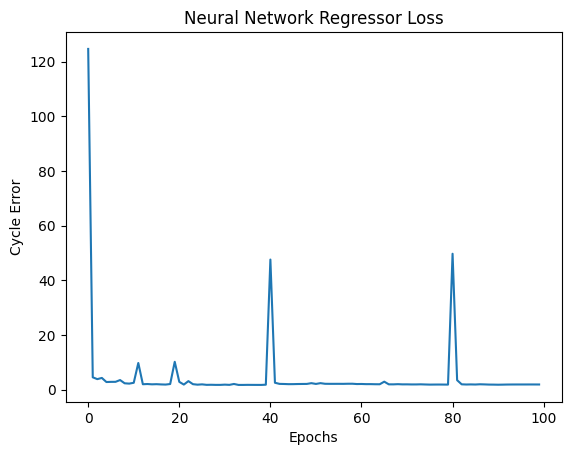

In [67]:
# Neural Network Regression MSE
nn_pred = nn_reg.predict(x_test)
print(mean_squared_error(y_true=y_test, y_pred=nn_pred))

plt.plot(reg_loss.history['loss'])
plt.title("Neural Network Regressor Loss")
plt.xlabel("Epochs")
plt.ylabel("Cycle Error")
plt.show()

In [68]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)  # You can tune alpha later
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

aspect_names = columns  # or provide aspect column names directly
coefficients = ridge.coef_

# Get top contributing aspects
top_positive = sorted(zip(coefficients, aspect_names), reverse=True)[:10]
top_negative = sorted(zip(coefficients, aspect_names))[:10]

print("Top Positive Aspects:")
for coef, name in top_positive:
    print(f"{name}: {coef:.4f}")

print("\nTop Negative Aspects:")
for coef, name in top_negative:
    print(f"{name}: {coef:.4f}")

aspect_map = dict(zip(columns, coefficients))
for key, value in aspect_map.items():
    print(key, value)

MSE: 1.9318
Top Positive Aspects:
egg french fry: 1.3115
flavor sampler: 1.2958
sarracenia: 1.2860
egg fry bread: 1.2762
one cup decaf: 1.2568
quality produce: 1.2456
chai brew: 1.2386
noodles flavor: 1.1929
ice cream scoop: 1.1855
blueberry pancake mix: 1.1775

Top Negative Aspects:
lemon mint flavor: -2.3530
shortcake: -2.2115
basom: -2.0985
acidy taste: -2.0294
nori taste: -1.7881
gyro: -1.7774
sodium aluminum phosphate: -1.6800
wabash valley: -1.6665
galil turkish delight: -1.6261
lie flat: -1.5860
ProductId -1.318983034146245e-07
Score 0.0
1000 island dressing 0.3479093195235055
12 0.0
12 bottle 20 0.0
12 ounce 0.0
12 oz package 0.19099899277982343
14 0.20675820472266263
16 cup sampler 0.27463123487737356
16 ounce bottle 0.30811365845265537
16 oz chili powder 0.2368570668087361
24 0.3495210626294151
32 -0.48379721497673867
32 fluid oz container -0.06959685562541117
32 ounce bottle 0.24004053816435975
32 ounce container 0.0
32 oz 0.22740545483713331
3d style -0.37307928926051087
3s

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

print("Top Contributing Aspects:")
for idx in sorted_idx[:10]:
    print(f"{aspect_names[idx]}: {importances[idx]:.4f}")

MSE: 2.0967
Top Contributing Aspects:
ProductId: 0.2461
flavoniod content: 0.0131
prezzo: 0.0117
tast: 0.0105
suey: 0.0069
coffe taste: 0.0059
textura: 0.0057
tchibo coffee: 0.0053
shippin price: 0.0052
chocolat en: 0.0046


683/683 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2046
         1.0       0.00      0.00      0.00      1136
         2.0       0.00      0.00      0.00      1516
         3.0       0.20      0.00      0.00      2815
         4.0       0.66      1.00      0.79     14341

    accuracy                           0.66     21854
   macro avg       0.17      0.20      0.16     21854
weighted avg       0.46      0.66      0.52     21854



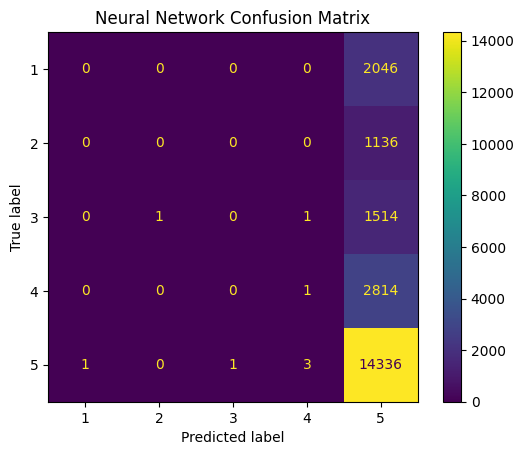

In [70]:
nn_pred = nn_class.predict(x_test)
nn_pred = [np.argmax(arr) for arr in nn_pred]
print(classification_report(y_true=y_test, y_pred=nn_pred))

cm = confusion_matrix(y_true=y_test, y_pred=nn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Neural Network Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

         0.0       0.15      0.10      0.12      2046
         1.0       0.08      0.03      0.04      1136
         2.0       0.08      0.03      0.05      1516
         3.0       0.15      0.09      0.11      2815
         4.0       0.67      0.83      0.74     14341

    accuracy                           0.57     21854
   macro avg       0.22      0.21      0.21     21854
weighted avg       0.48      0.57      0.52     21854



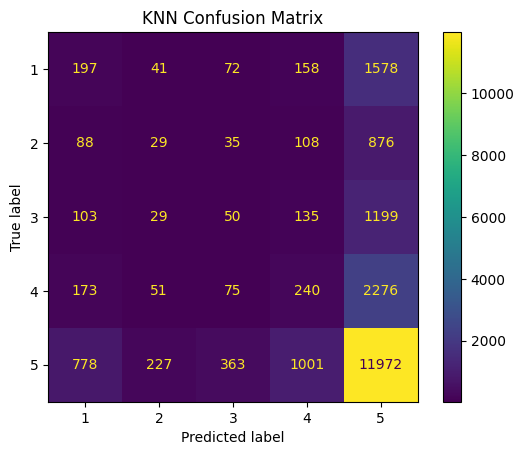

In [71]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
print(classification_report(y_pred=knn_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("KNN Confusion Matrix")
plt.show()

              precision    recall  f1-score   support

         0.0       0.09      0.04      0.06      2046
         1.0       0.07      0.03      0.04      1136
         2.0       0.08      0.03      0.05      1516
         3.0       0.14      0.06      0.09      2815
         4.0       0.66      0.85      0.74     14341

    accuracy                           0.58     21854
   macro avg       0.21      0.20      0.19     21854
weighted avg       0.47      0.58      0.51     21854



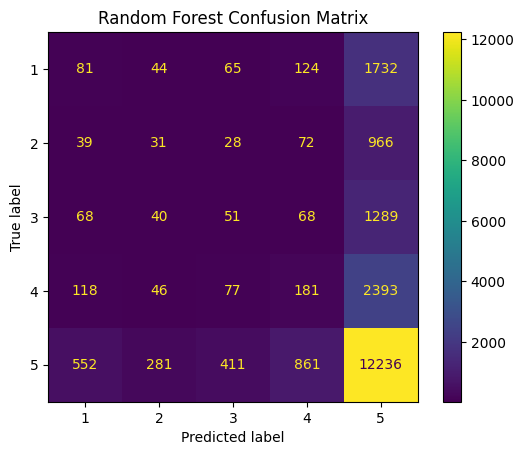

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_pred=rf_pred, y_true=y_test))

cm = confusion_matrix(y_true=y_test, y_pred=rf_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "2", "3", "4", "5"])

disp.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()